# CHAPTER 1: Exploratory Data Analysis

Import required Python packages

In [1]:
import os

import pandas as pd
import numpy as np

import datetime

from scipy import stats

from prettytable import PrettyTable

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

Define paths to data sets.

In [2]:
DATA = os.getcwd()

AIRLINE_STATS_CSV = os.path.join(DATA, 'airline_stats.csv')
KC_TAX_CSV = os.path.join(DATA, 'kc_tax.csv.gz')
LC_LOANS_CSV = os.path.join(DATA, 'lc_loans.csv')
AIRPORT_DELAYS_CSV = os.path.join(DATA, 'dfw_airline.csv')
SP500_DATA_CSV = os.path.join(DATA, 'sp500_data.csv.gz')
SP500_SECTORS_CSV = os.path.join(DATA, 'sp500_sectors.csv')
STATE_CSV = os.path.join(DATA, 'state.csv')

## Estimates of Location

### Example: Location Estimates of Population and Murder Rates

In [3]:
state = pd.read_csv('state.csv').sort_values(by=['Population']) # read document

state.head(5)

State  Population  Murder.Rate Abbreviation
49       Wyoming      563626          2.7           WY
44       Vermont      625741          1.6           VT
33  North Dakota      672591          3.0           ND
1         Alaska      710231          5.6           AK
40  South Dakota      814180          2.3           SD

Create a Pretty Table

In [4]:
table = PrettyTable()

table.field_names = ['Mean' , 'Trimmed Mean', 'Weighted Mean', 'Median']

table.add_row(
    [
        np.mean(state['Population']),
        stats.trim_mean(state['Population'], 0.1),
        np.average(state['Murder.Rate'], weights = state['Population'] ),
        np.median(state['Population'])
    ]
)

print(table)

+-----------+--------------+-------------------+-----------+
|    Mean   | Trimmed Mean |   Weighted Mean   |   Median  |
+-----------+--------------+-------------------+-----------+
| 6162876.3 | 4783697.125  | 4.445833981123393 | 4436369.5 |
+-----------+--------------+-------------------+-----------+


In [5]:
# function that return the weighted median.
def weighted_median(value, weight) -> float:
    df = pd.DataFrame(data=[value,weight]).T
    df = df.sort_values(by=df.columns[0]).reset_index(drop=True)
    value = df.iloc[:,0]
    weight = df.iloc[:,1]

    wCeil = 0
    iterator = 0
    half = sum(weight)/2

    while wCeil < half:
        wCeil += weight[iterator]
        iterator+=1

    wFloor = wCeil - weight[iterator-1]
    vCeil = value[iterator]
    vFloor = value[iterator-2]

    return vFloor + ((half - wFloor) / (wCeil - wFloor)) * (vCeil - vFloor)

In [6]:
wMedian = weighted_median(state['Murder.Rate'], state['Population']) # weighted median

table = PrettyTable()

table.field_names = ['Weighted Median']

table.add_row([wMedian])

print(table)

+-------------------+
|  Weighted Median  |
+-------------------+
| 4.421634381114027 |
+-------------------+


### Estimates of Variability

In [7]:
# median absolute deviation
def mad(data, axis=None):
    return np.median(np.absolute(data - np.median(data, axis)), axis)

It's importante to note that the corrected median absolute
deviation does not approach the standard desviation, which
can signals that the correction is not adequate.

In [8]:
table = PrettyTable()

table.field_names = ['Standard Desviatio','Interquartile Range','Median Absolute Desviation', 'Corrected MAD']

table.add_row(
    [
        state['Population'].std(),
        stats.iqr(state['Population']),
        mad(state['Population']),
        mad(state['Population']) * 1.4826
    ]
)

print(table)

+--------------------+---------------------+----------------------------+---------------+
| Standard Desviatio | Interquartile Range | Median Absolute Desviation | Corrected MAD |
+--------------------+---------------------+----------------------------+---------------+
| 6848235.347401142  |      4847308.0      |         2596702.0          |  3849870.3852 |
+--------------------+---------------------+----------------------------+---------------+


Note that numpy standard desviation Degree of Freedom is N not N-1

In [9]:
n = state['Population'].count()
c = np.sqrt((n)/(n-1))

np.std( state['Population'].values) * c

6848235.347401144

## Percentiles and Boxplots

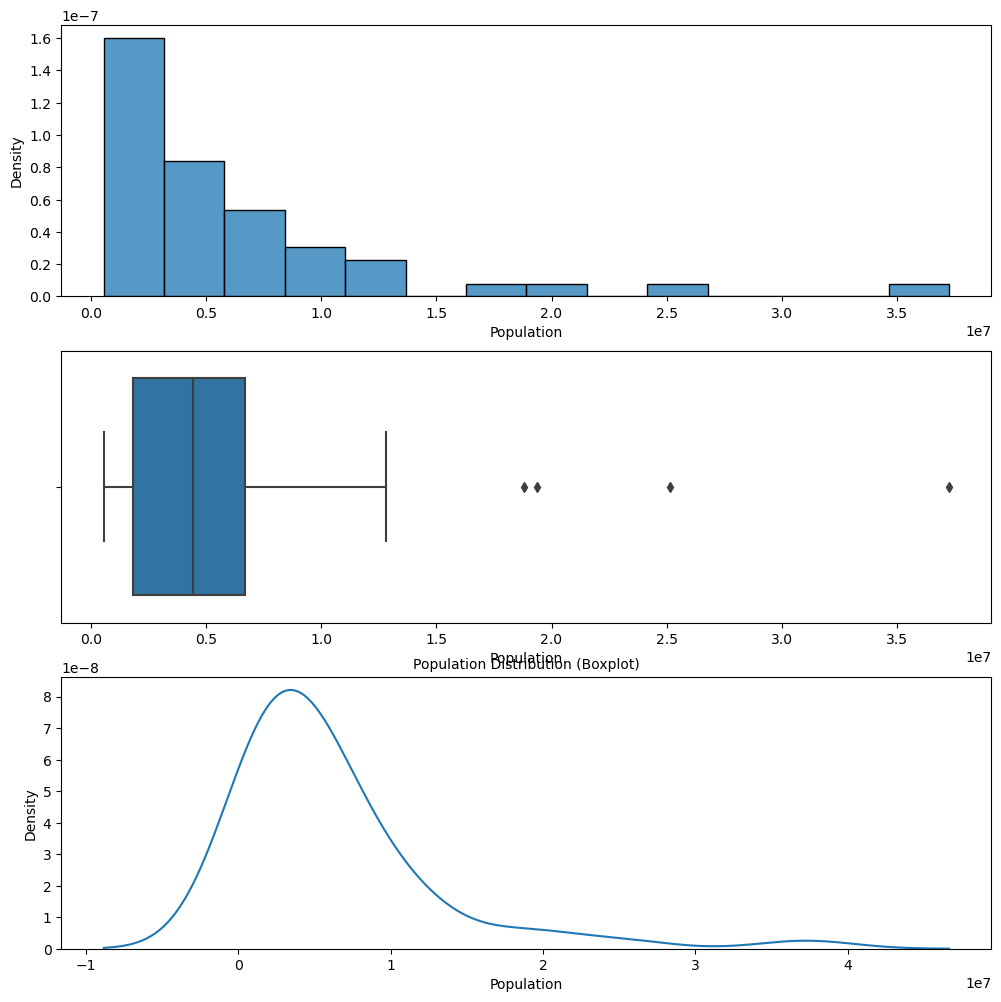

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

sns.histplot(data=state, x='Population', stat='density', ax=axes[0])
plt.title('Population Distribution (Histogram)', fontsize=10, loc='center')

sns.boxplot(data=state, x='Population', ax=axes[1])
plt.title('Population Distribution (Boxplot)', fontsize=10, loc='center')

sns.kdeplot(data=state, x='Population',ax=axes[2])

plt.show()

#The distribution os the population does not appear to
#correspond to the normal distribution

In [11]:
stat, p = stats.shapiro(state['Population'])
print(f"Shapiro-Wilk Test: Estatística={stat:.4f}, p={p:.4f}")

# Teste de Kolmogorov-Smirnov
stat, p = stats.kstest(state['Population'], 'norm')
print(f"Kolmogorov-Smirnov Test: Estatística={stat:.4f}, p={p:.4f}")

# Teste de D’Agostino (normaltest)
stat, p = stats.normaltest(state['Population'])
print(f"D’Agostino’s K-squared Test: Estatística={stat:.4f}, p={p:.4f}")


# Test interpretation
# if the p-value is greater then 0.05, we do not reject H0, indicating 
# that the data can be considered normal. 

# else, we reject H0

Shapiro-Wilk Test: Estatística=0.7192, p=0.0000
Kolmogorov-Smirnov Test: Estatística=1.0000, p=0.0000
D’Agostino’s K-squared Test: Estatística=47.0611, p=0.0000


In [12]:
# Visualizing the percentiles

quantiles = np.quantile(state['Murder.Rate'],q=[0.05, 0.25, 0.5, 0.75, 0.95])
percentiles = ['5%','25%','50%','75%','95%']

df = pd.DataFrame(quantiles.reshape(1, -1), columns=percentiles)

df

5%    25%  50%   75%   95%
0  1.6  2.425  4.0  5.55  6.51

In [13]:
#displaing the frequncy table
dfState = state
num_bins = 11

# Criando os intervalos
bins = np.linspace(state['Population'].min(), state['Population'].max(), num_bins)

pop_freq = pd.cut(state['Population'], bins, include_lowest=True)

dfState['Population'] = pop_freq

In [14]:
dfState.groupby('Population').agg({'State': 'count' ,'Abbreviation': list})

State  \
Population                        
(563625.999, 4232659.0]      24   
(4232659.0, 7901692.0]       14   
(7901692.0, 11570725.0]       6   
(11570725.0, 15239758.0]      2   
(15239758.0, 18908791.0]      1   
(18908791.0, 22577824.0]      1   
(22577824.0, 26246857.0]      1   
(26246857.0, 29915890.0]      0   
(29915890.0, 33584923.0]      0   
(33584923.0, 37253956.0]      1   

                                                               Abbreviation  
Population                                                                   
(563625.999, 4232659.0]   [WY, VT, ND, AK, SD, DE, MT, RI, NH, ME, HI, I...  
(4232659.0, 7901692.0]    [KY, LA, SC, AL, CO, MN, WI, MD, MO, TN, AZ, I...  
(7901692.0, 11570725.0]                            [VA, NJ, NC, GA, MI, OH]  
(11570725.0, 15239758.0]                                           [PA, IL]  
(15239758.0, 18908791.0]                                               [FL]  
(18908791.0, 22577824.0]                                               [NY]  
(22577824.0, 26246857.0]                                               [TX]  
(26246857.0, 29915890.0]                                                 []  
(29915890.0, 33584923.0]                                                 []  
(33584923.0, 37253956.0]                                               [CA]

<AxesSubplot:xlabel='Murder.Rate', ylabel='Density'>

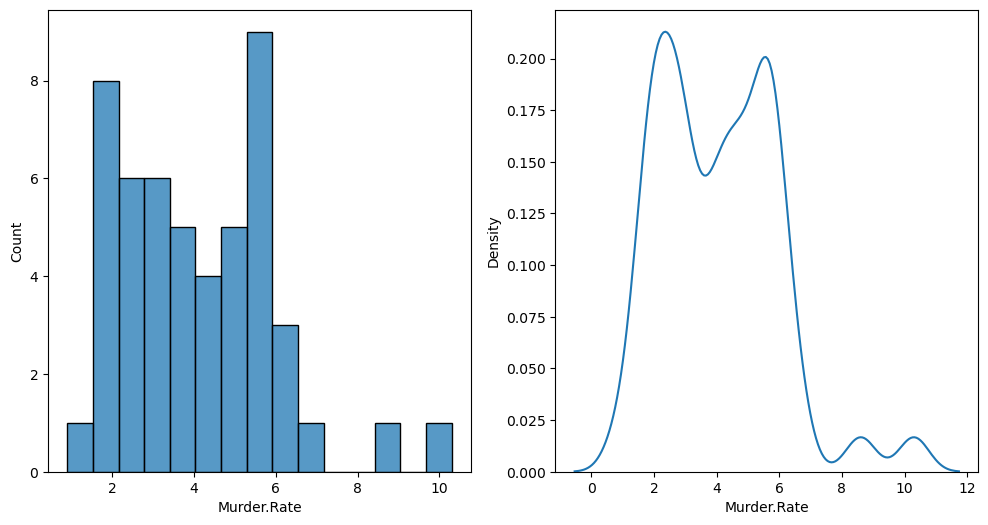

In [15]:
# Analizing the distribuition through a histogram and a KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(state['Murder.Rate'], bins=15, ax=axes[0])

sns.kdeplot(state['Murder.Rate'], ax=axes[1], bw_method=0.25)

In [16]:
# my KED study
x = 2  # Ponto em que o KDE será calculado
h = 0.25  # Largura de banda

# Função Kernel Gaussiano
def kernel_gaussiano(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

In [17]:
# my KED study
u = (x - state['Murder.Rate']) / h
n = len(state['Murder.Rate'])

kernels = kernel_gaussiano(u)

kde_x = np.sum(kernels) / (n * h)  # Estimativa de densidade

kde_x

0.22907902291584456

In [18]:
x = np.linspace(0, 1, 100)

y1 = np.sin(4*x) + np.random.normal(0, 1/3, 100)
y2 = np.sin(4*x)

In [19]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=30)  # Escolhendo k=5

knn.fit(x.reshape(-1, 1), y1)

lista = []
for s in x:
    lista.append(knn.predict([[s]])[0] )

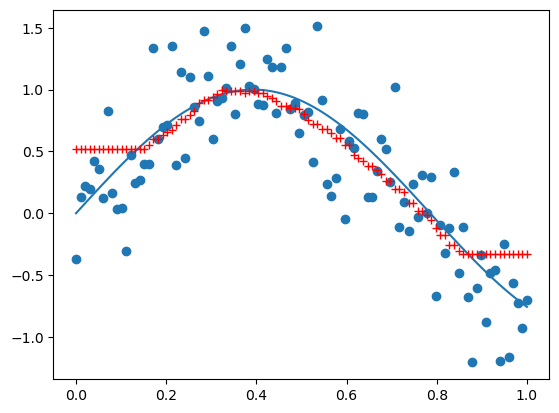

In [20]:
plt.scatter(x, y1)
plt.plot(x,y2)
plt.plot(x,np.array(lista),'r+')

In [21]:
# Table 1-6
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
dfw

Carrier      ATC   Weather  Security    Inbound
0  64263.16  84856.5  11235.42    343.15  118427.82

In [22]:
print(dfw) 

    Carrier      ATC   Weather  Security    Inbound
0  64263.16  84856.5  11235.42    343.15  118427.82


In [23]:
dfw*100 / dfw.values.sum() #percentege

Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079

<AxesSubplot:>

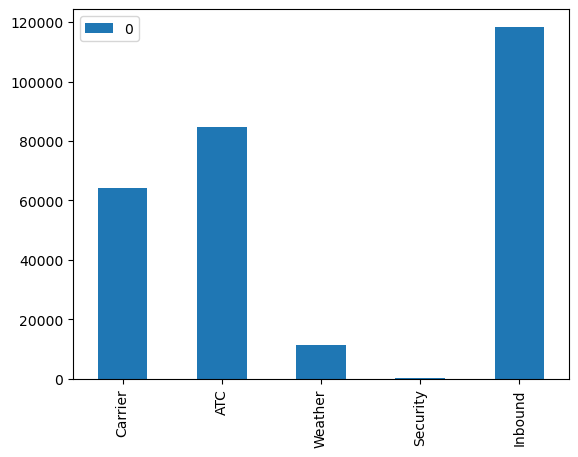

In [24]:
dfw.transpose().plot.bar()

array([<AxesSubplot:ylabel='0'>], dtype=object)

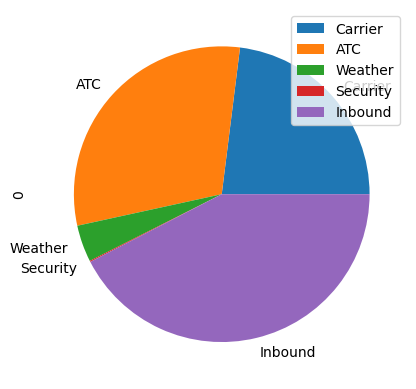

In [25]:
dfw.transpose().plot.pie(subplots=True)

In [26]:
sp500_sym  = pd.read_csv(SP500_SECTORS_CSV)

telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

In [27]:
sp500_px = pd.read_csv(SP500_DATA_CSV,index_col=0)

telecom = sp500_px.loc['2012-07-01': , telecomSymbols]

In [28]:
telecom.corr()

T       CTL       FTR        VZ      LVLT
T     1.000000  0.474683  0.327767  0.677612  0.278626
CTL   0.474683  1.000000  0.419757  0.416604  0.286665
FTR   0.327767  0.419757  1.000000  0.287386  0.260068
VZ    0.677612  0.416604  0.287386  1.000000  0.242199
LVLT  0.278626  0.286665  0.260068  0.242199  1.000000

In [29]:
etfsSymbols = sp500_sym[sp500_sym['sector'] == 'etf']['symbol']

etfs = sp500_px.loc['2012-07-01': , etfsSymbols]

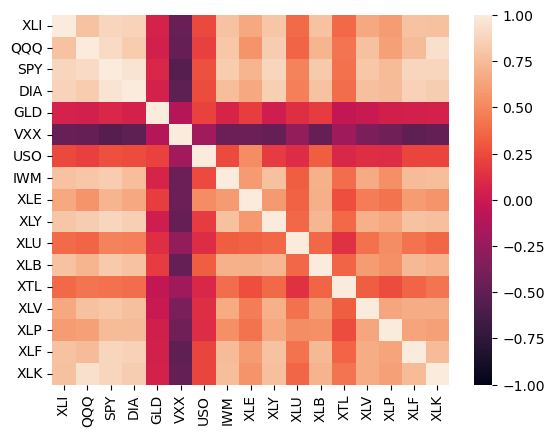

In [30]:
sns.heatmap(etfs.corr(),
           vmin=-1,
           vmax=1)

px.imshow(etfs.corr(), text_auto=True, aspect="auto")

<AxesSubplot:xlabel='SPY', ylabel='DIA'>

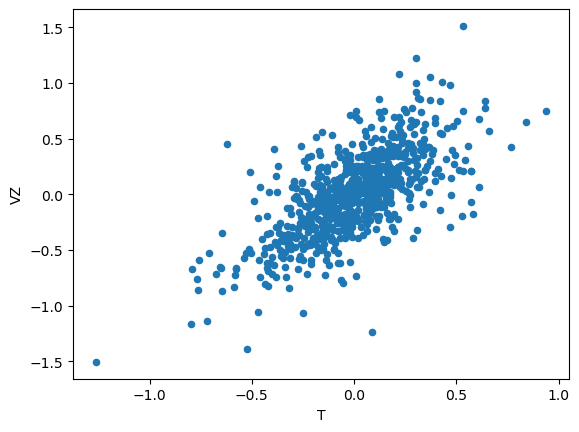

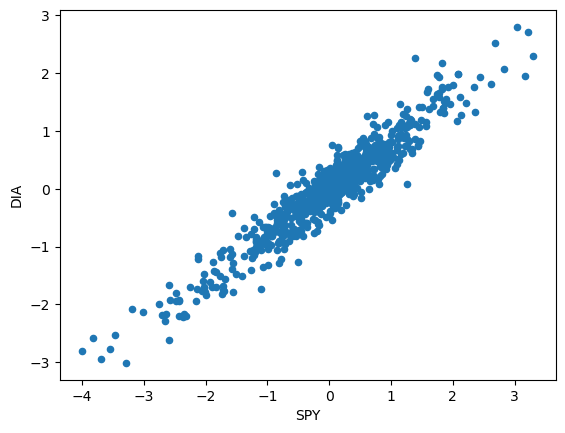

In [31]:
telecom.plot.scatter(x='T',y='VZ')

etfs.plot.scatter(x='SPY',y='DIA')

In [32]:
kc_tax = pd.read_csv(KC_TAX_CSV)

kc_tax0 = kc_tax.query('TaxAssessedValue<750000 and SqFtTotLiving>100 and SqFtTotLiving<3500')

kc_tax0.shape[0]

432693

<AxesSubplot:xlabel='SqFtTotLiving', ylabel='TaxAssessedValue'>

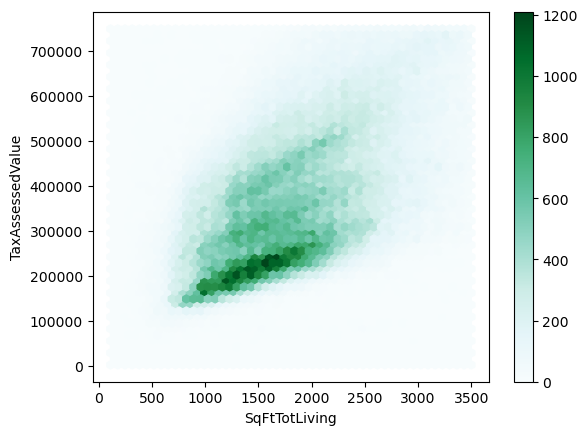

In [33]:
kc_tax0.plot.hexbin(x='SqFtTotLiving',y='TaxAssessedValue',
                   gridsize=50)

<AxesSubplot:xlabel='SqFtTotLiving', ylabel='TaxAssessedValue'>

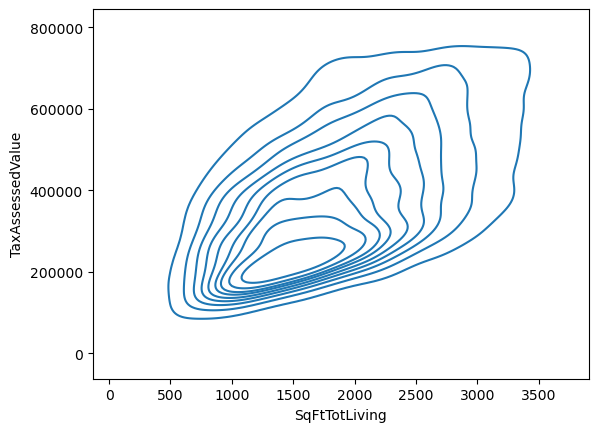

In [34]:
sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue')

from scipy.stats import gaussian_kde

# Dados de exemplo
x = kc_tax0['SqFtTotLiving']
y = kc_tax0['TaxAssessedValue']

# Calcular a densidade bivariada
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
z = kde(xy)

# Criar o gráfico
plt.scatter(x, y, c=z, cmap='viridis', s=1)
plt.colorbar(label='Densidade')
plt.xlabel('SqFtTotLiving')
plt.ylabel('TaxAssessedValue')
plt.title('KDE Bivariado')
plt.show()

In [35]:
lc_loans = pd.read_csv(LC_LOANS_CSV)

lc_loans

status grade
0        Fully Paid     B
1       Charged Off     C
2        Fully Paid     C
3        Fully Paid     C
4           Current     B
...             ...   ...
450956      Current     D
450957      Current     D
450958      Current     D
450959      Current     D
450960   Fully Paid     A

[450961 rows x 2 columns]

In [36]:
pd.crosstab(lc_loans['grade'], lc_loans['status'],normalize='index')

status  Charged Off   Current  Fully Paid      Late
grade                                              
A          0.021548  0.690454    0.281528  0.006470
B          0.040054  0.709013    0.235401  0.015532
C          0.049828  0.735702    0.191495  0.022974
D          0.067410  0.717328    0.184189  0.031073
E          0.081657  0.707936    0.170929  0.039478
F          0.118258  0.654371    0.180409  0.046962
G          0.126196  0.614008    0.198396  0.061401

In [37]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)

In [38]:
airline_stats

pct_carrier_delay  pct_atc_delay  pct_weather_delay    airline
0               8.153226       1.971774           0.762097   American
1               5.959924       3.706107           1.585878   American
2               7.157270       2.706231           2.026706   American
3              12.100000      11.033333           0.000000   American
4               7.333333       3.365591           1.774194   American
...                  ...            ...                ...        ...
33463           6.186422       8.798491           1.651940  Southwest
33464           9.522167       3.591133           0.261084  Southwest
33465           9.164179       2.664179           0.343284  Southwest
33466           5.152293       1.964520           0.122817  Southwest
33467           3.964393       1.700479           0.019449  Southwest

[33468 rows x 4 columns]

(0.0, 50.0)

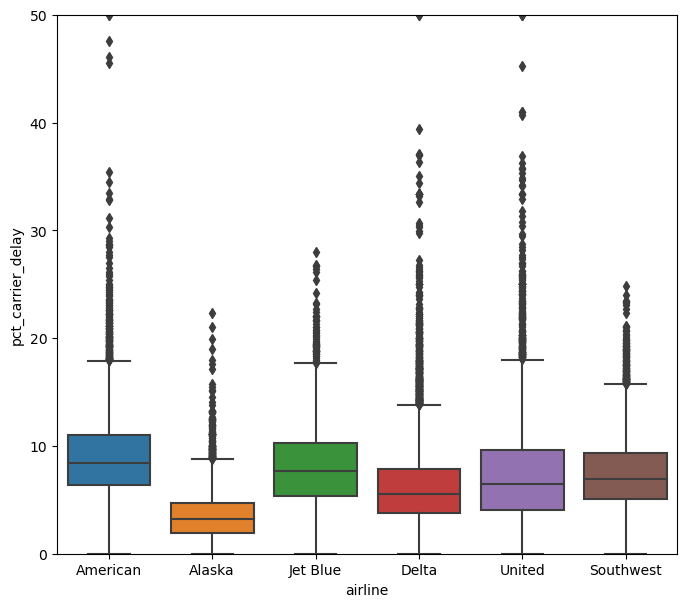

In [39]:
plt.figure(figsize=(8,7))
sns.boxplot(x='airline', y='pct_carrier_delay', data=airline_stats)

plt.ylim(0,50)

In [40]:
airline_stats

pct_carrier_delay  pct_atc_delay  pct_weather_delay    airline
0               8.153226       1.971774           0.762097   American
1               5.959924       3.706107           1.585878   American
2               7.157270       2.706231           2.026706   American
3              12.100000      11.033333           0.000000   American
4               7.333333       3.365591           1.774194   American
...                  ...            ...                ...        ...
33463           6.186422       8.798491           1.651940  Southwest
33464           9.522167       3.591133           0.261084  Southwest
33465           9.164179       2.664179           0.343284  Southwest
33466           5.152293       1.964520           0.122817  Southwest
33467           3.964393       1.700479           0.019449  Southwest

[33468 rows x 4 columns]

In [41]:
dfMelt = pd.melt(airline_stats, id_vars=['airline'], var_name='delay_type', value_name='value')

dfMelt

airline         delay_type      value
0        American  pct_carrier_delay   8.153226
1        American  pct_carrier_delay   5.959924
2        American  pct_carrier_delay   7.157270
3        American  pct_carrier_delay  12.100000
4        American  pct_carrier_delay   7.333333
...           ...                ...        ...
100399  Southwest  pct_weather_delay   1.651940
100400  Southwest  pct_weather_delay   0.261084
100401  Southwest  pct_weather_delay   0.343284
100402  Southwest  pct_weather_delay   0.122817
100403  Southwest  pct_weather_delay   0.019449

[100404 rows x 3 columns]

(0.0, 50.0)

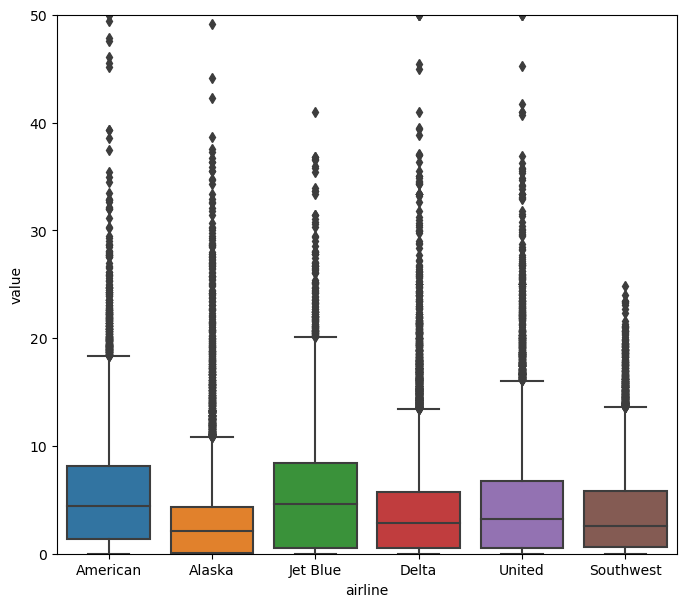

In [42]:
plt.figure(figsize=(8,7))
sns.boxplot(data=dfMelt, y='value',x='airline')

plt.ylim(0,50)

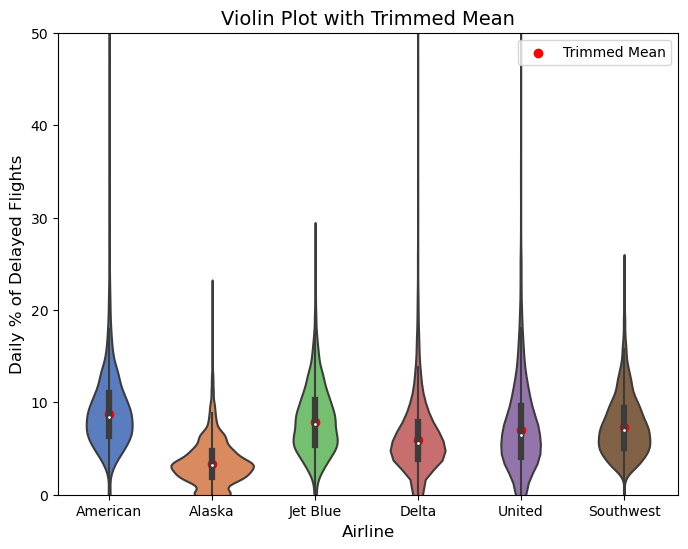

In [43]:
plt.figure(figsize=(8, 6))

# Criar o violin plot
sns.violinplot(x='airline', y='pct_carrier_delay', data=airline_stats, palette='muted')

# Calcular e adicionar a trimmed mean (média aparada)
airlines = airline_stats['airline'].unique()
for airline in airlines:
    # Filtrar os dados por companhia aérea
    values = airline_stats[airline_stats['airline'] == airline]['pct_carrier_delay']
    
    # Calcular a média aparada (trimming de 10%)
    mean = stats.trim_mean(values, proportiontocut=0.05)
    
    # Adicionar ao gráfico como um ponto
    x_pos = list(airlines).index(airline)  # Posição no eixo X
    plt.scatter(x_pos, mean, color='red', label='Trimmed Mean' if airline == airlines[0] else "")

# Configurações do gráfico
plt.ylim(0, 50)  # Ajuste o limite do eixo Y conforme necessário
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Daily % of Delayed Flights', fontsize=12)
plt.title('Violin Plot with Trimmed Mean', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [44]:
kc_tax0_dropped = kc_tax0.dropna(subset='ZipCode')

kc_tax0_dropped.ZipCode = kc_tax0_dropped.ZipCode.astype(int)

C:\Users\ander\AppData\Local\Temp\ipykernel_912\826893868.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
filtered_data

NameError: name 'filtered_data' is not defined

In [ ]:
kc_tax0[kc_tax0['ZipCode'].notna()]['ZipCode'].unique()[:11].astype(int)

In [ ]:
zipcodes = kc_tax0[kc_tax0['ZipCode'].notna()]['ZipCode'].unique()[:10].astype(int)

filtered_data = kc_tax0[kc_tax0['ZipCode'].isin(zipcodes)]

g = sns.FacetGrid(
    filtered_data,
    col='ZipCode',
    col_wrap=2,
    height=5,
sharex=True,
sharey=True)

g.map(
    plt.hexbin,
    'SqFtTotLiving',
    'TaxAssessedValue',
    gridsize=30,
    cmap='Blues'
)